In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from caveclient import CAVEclient

In [2]:
bin_width = 0.05
step_size = 0.005
y_resolution = 4  # nm per voxel

In [3]:
labels = np.array([107000, 147000, 184000, 224000, 265000]) * y_resolution / 1_000_000  # manual labels

# Gather data

In [4]:
datastack_name = "minnie65_public_v117"
client = CAVEclient(datastack_name)

In [5]:
nuclei = client.materialize.query_table("nucleus_detection_v0")

In [6]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id

In [7]:
valid_ids = set(all_cells.query("num_soma == 1").pt_root_id)

In [8]:
soma_features = pd.read_pickle("Minnie_soma_nuc_feature_model_83_1.pkl")

nuc_to_root = client.materialize.query_table("nucleus_neuron_svm")

nuc_to_root.index = nuc_to_root.id

soma_features["seg_id"] = [nuc_to_root.loc[n].pt_root_id for n in soma_features.nuc_id]
soma_features.index = soma_features.seg_id
soma_features.columns  
# size is equal to nucleus volume
# soma area and nucleus area closely track their respective volumes
# avg sdf is a list of the 'diameters' of processes (e.g. dendrites) that leave each cell body

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')

In [9]:
soma_features_root_ids = set(soma_features.seg_id)

In [34]:
features = ["soma_volume", "n_soma_syn", "nucleus_volume", "nucleus_fract_fold", "sum_proc_sdf", "nucleus_to_soma"]

In [35]:
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")

In [36]:
# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]]) + np.array([000_000, 0, 0]) # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

auto_col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox)].copy()
# add soma features columns to auto_col_cells
for feature in features:
    auto_col_cells[feature] = [(soma_features.loc[r][feature] if r in soma_features_root_ids and type(soma_features.loc[r][feature]) is not pd.Series else np.nan)
                           for r in auto_col_cells.pt_root_id]
auto_exc_cells = auto_col_cells.query("classification_system == 'aibs_coarse_excitatory'")
auto_inh_cells = auto_col_cells.query("classification_system == 'aibs_coarse_inhibitory'")

In [37]:
bbox

array([[168111.,  50000.,  20133.],
       [193111., 323500.,  22633.]])

In [38]:
cell_types = ["exc", "BC", "BPC", "MC", "NGC"]
ctype_to_layer = {"23P": "23",
                 "4P": "4",
                 "5P_PT": "5",
                 "5P_IT": "5",
                 "5P_NP": "5",
                 "6P": "6",
                 "6CT": "6",
                 "6IT": "6"}

## Synapses in the center of the column

In [54]:
syn_bbox = bbox.copy()
sample_width = 10_000  # nm square cross section
x_vx_width = sample_width / resolution[0]
z_vx_width = sample_width / resolution[2]
syn_bbox[0, 0] = bbox[0, 0] + (bbox[1, 0] - bbox[0, 0]) / 2
syn_bbox[1, 0] = syn_bbox[0, 0] + x_vx_width
syn_bbox[0, 2] = bbox[0, 2] + (bbox[1, 2] - bbox[0, 2]) / 2
syn_bbox[1, 2] = syn_bbox[0, 2] + z_vx_width
syn_bbox, bbox

(array([[205611.,  50000.,  21383.],
        [208111., 323500.,  21633.]]),
 array([[193111.,  50000.,  20133.],
        [218111., 323500.,  22633.]]))

In [ ]:
synapses = client.materialize.synapse_query(bounding_box=syn_bbox, bounding_box_column="ctr_pt_position", split_positions=True)

In [ ]:
synapses["pre_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.pre_pt_root_id]
synapses["post_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.post_pt_root_id]
syn_depths = synapses.ctr_pt_position_y.values * y_resolution / 1_000_000
syn_depths_by_pre = dict((t, []) for t in cell_types)
syn_depths_by_post = dict((t, []) for t in cell_types)
for i in synapses.index:
    # pre
    syn = synapses.loc[i]
    if syn.pre_type in ctype_to_layer.keys():
        syn_depths_by_pre["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.pre_type in syn_depths_by_pre.keys():
        syn_depths_by_pre[syn.pre_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    
    # post
    if syn.post_type in ctype_to_layer.keys():
        syn_depths_by_post["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.post_type in syn_depths_by_post.keys():
        syn_depths_by_post[syn.post_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
for t in syn_depths_by_pre:
    syn_depths_by_pre[t] = np.array(syn_depths_by_pre[t])
for t in syn_depths_by_post:
    syn_depths_by_post[t] = np.array(syn_depths_by_post[t])

synapses

In [39]:
# cross sectional area to be layered
xarea = resolution[0] * resolution[2] * (bbox[1][0] - bbox[0][0]) * (bbox[1][2] - bbox[0][2]) / 1_000_000 ** 2

In [40]:
# min is pia border (with L1) and max is white matter border (with L6)
min_y = min(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
max_y = max(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
min_y, max_y

(0.358016, 1.086656)

### Sort the dataframe of cells by depth to make getting features by depth way faster

In [41]:
auto_col_cells = auto_col_cells.sort_values(axis="index", by="pt_position", key=lambda xs: pd.Series([x[1] for x in xs]))

def get_cutoff_idx(df, y, prev_cutoff_idx, position_col="pt_position"):
    """efficiently find the first index after prev_cutoff_idx where position[1] is greater than y"""
    i = prev_cutoff_idx
    if i >= len(df):
        return i
    while df.iloc[i][position_col][1] * y_resolution / 1_000_000 < y:
        i += 1
        if i >= len(df):
            return i
    return i  # new_cutoff_idx

In [42]:
exc_soma_densities = []
inh_soma_densities = []
synapse_densities = []
# syn_densities_by_pre = dict((t, []) for t in syn_depths_by_pre.keys())
# syn_densities_by_post = dict((t, []) for t in syn_depths_by_post.keys())
p_type = dict((t, []) for t in ["23", "4", "5", "6"])
p_inh_subclass = dict((t, []) for t in ["BC", "BPC", "MC", "NGC"])
exc_soma_features_by_depth = dict((f, []) for f in features)
inh_soma_features_by_depth = dict((f, []) for f in features)
soma_features_by_depth = dict((f, []) for f in features)
exc_soma_vol_std_by_depth = []
exc_soma_depths = []
bin_centers = []

depths = np.arange(min_y, max_y, step_size)
bin_centers = depths + step_size // 2
prev_cutoff_idx = 0
for curr_y in depths:
    # first index where pt_position[1] is greater than curr_y + bin_width 
    cutoff_idx = get_cutoff_idx(auto_col_cells, curr_y + bin_width, prev_cutoff_idx)
    lower_cutoff_idx = get_cutoff_idx(auto_col_cells, curr_y, prev_cutoff_idx)
    
    current_cells = auto_col_cells.iloc[lower_cutoff_idx:cutoff_idx]
    current_exc_cells = current_cells.query("classification_system == 'aibs_coarse_excitatory'")
    current_inh_cells = current_cells.query("classification_system == 'aibs_coarse_inhibitory'")
    
    for f in features:
        soma_features_by_depth[f].append(current_cells[f].mean())
        exc_soma_features_by_depth[f].append(current_exc_cells[f].mean())
        inh_soma_features_by_depth[f].append(current_inh_cells[f].mean())
    exc_soma_vol_std_by_depth.append(current_exc_cells["soma_volume"].std())
    mean_pos = current_exc_cells["pt_position"].mean()
    exc_soma_depths.append((mean_pos[1] if mean_pos is not np.nan else np.nan))
                          
    for t in p_type:
        p_type[t].append(0)
    for i in current_exc_cells.index:
        if current_exc_cells.loc[i].cell_type != "Unsure":
            p_type[ctype_to_layer[current_exc_cells.loc[i].cell_type]][-1] += 1 / len(current_exc_cells) if len(current_exc_cells) > 0 else np.nan
    exc_soma_densities.append(len(current_exc_cells))
    
    inh_soma_densities.append(len(current_inh_cells))
    for t in p_inh_subclass:
        p_inh_subclass[t].append(0)
    for i in current_inh_cells.index:
        if current_inh_cells.loc[i].cell_type != "Unsure":
            p_inh_subclass[current_inh_cells.loc[i].cell_type][-1] += 1 / len(current_inh_cells) if len(current_inh_cells) > 0 else np.nan
            
    # # this is still slow
    # synapse_densities.append(sum((curr_y <= syn_depths) & (syn_depths < curr_y + bin_width)))
    # for t in syn_densities_by_pre.keys():
    #     syn_densities_by_pre[t].append(sum((curr_y <= syn_depths_by_pre[t]) & (syn_depths_by_pre[t] < curr_y + bin_width)))
    # for t in syn_densities_by_post.keys():
    #     syn_densities_by_post[t].append(sum((curr_y <= syn_depths_by_post[t]) & (syn_depths_by_post[t] < curr_y + bin_width)))
    
    prev_cutoff_idx = lower_cutoff_idx
exc_soma_densities = np.array(exc_soma_densities, dtype=float) / (bin_width * xarea)  # per mm^3
inh_soma_densities = np.array(inh_soma_densities, dtype=float) / (bin_width * xarea)
# synapse_densities = np.array(synapse_densities, dtype=float) / (bin_width * xarea)
for t in p_type:
    p_type[t] = np.array(p_type[t])
for t in p_inh_subclass:
    p_inh_subclass[t] = np.array(p_inh_subclass[t])
# for t in syn_densities_by_pre:
#     syn_densities_by_pre[t] = np.array(syn_densities_by_pre[t]) / (bin_width * xarea)
# for t in syn_depths_by_post:
#     syn_densities_by_post[t] = np.array(syn_densities_by_post[t]) / (bin_width * xarea)

In [43]:
def clean_nans(x, normalize=False):
    """linearly interpolates to fill in nans
    normalizing subtracts mean and divides by std
    """
    cleaned = np.array(x)
    mask = np.isfinite(cleaned)
    cleaned = np.interp(np.arange(len(cleaned)), np.arange(len(cleaned))[mask], cleaned[mask])
    if normalize:
        cleaned -= cleaned.mean()
        cleaned /= cleaned.std()
    return cleaned

In [44]:
exc_features_df = pd.DataFrame(exc_soma_features_by_depth)
exc_features_df["soma_density"] = exc_soma_densities
exc_features_df["soma_vol_std"] = exc_soma_vol_std_by_depth
for col in exc_features_df.columns:
    exc_features_df[col] = clean_nans(exc_features_df[col], normalize=True)
exc_features_df

,soma_volume,n_soma_syn,nucleus_volume,nucleus_fract_fold,sum_proc_sdf,nucleus_to_soma,soma_density,soma_vol_std
0,-0.361149,1.056956,-0.482037,-1.307653,0.073811,-0.010727,-2.459284,-0.510483
1,0.072851,1.352864,0.024528,-1.119267,0.488860,-0.483754,-2.333443,-0.372161
2,-0.496472,1.149017,-0.671847,-0.777104,-0.160848,0.201132,-2.239062,-0.200191
3,-0.561166,1.066820,-0.658463,-0.773483,-0.160015,0.407955,-2.144682,-0.353769
4,-0.508450,1.066203,-0.562224,-0.787083,0.121552,0.415325,-2.018841,-0.239253
...,...,...,...,...,...,...,...,...
141,0.513799,-1.936269,0.798473,0.064612,-0.453667,-0.511446,-2.050301,-0.416314
142,0.892940,-2.020489,0.647528,-1.164225,-0.009569,-1.856223,-2.333443,-0.119303
143,0.892940,-2.020489,0.647528,-1.164225,-0.009569,-1.856223,-2.490744,-0.119303
144,0.892940,-2.020489,0.647528,-1.164225,-0.009569,-1.856223,-2.490744,-0.119303


### PCA on the features to remove correlations

(<matplotlib.image.AxesImage at 0x13d72405a20>,
 <matplotlib.colorbar.Colorbar at 0x13d7243f390>)

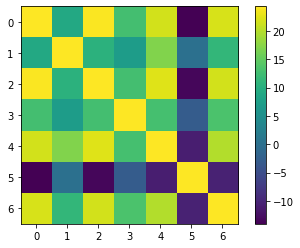

In [72]:
X = exc_features_df.values.T
Xc = X - np.mean(X, axis=1, keepdims=True)  # mean subtract data first
cov = Xc @ Xc.T / (X.shape[0] - 1)  # covariance
plt.imshow(cov), plt.colorbar()

In [73]:
variance, V = np.linalg.eig(cov)
idxs = np.argsort(-variance)
V = V[:, idxs]
variance = variance[idxs]
explained_variance = [sum(variance[:i+1]) / sum(variance) for i in range(len(variance))]

Text(0, 0.5, 'explained variance')

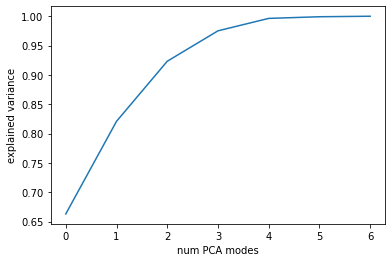

In [74]:
plt.plot(explained_variance)
plt.xlabel("num PCA modes")
plt.ylabel("explained variance")

In [75]:
# Yc is the projection of Xc onto the principal components 
Yc = V[:, :7].T @ Xc
Yc.shape

(7, 146)

### get inhibitory cell types for column to verify our boundaries
#### also excitatory subclasses

In [77]:
# cell_subtypes = pd.read_excel("CellTypesMinnieColumn.xlsx", sheet_name="csv", usecols=["Unnamed: 0", "Type-Nuno"])
# cell_subtypes.rename({"Unnamed: 0": "pt_position", "Type-Nuno": "subtype"}, axis=1, inplace=True)
# # convert the string position into a list of ints
# cell_subtypes["pt_position"] = [list(map(int, cell_subtypes["pt_position"].iloc[i][1:-1].split(", "))) for i in range(len(cell_subtypes))]
# cell_subtypes["mm_depth"] = [cell_subtypes["pt_position"].iloc[i][1] * 4 / 1_000_000 for i in range(len(cell_subtypes))]

In [45]:
auto_col_cells["mm_depth"] = [auto_col_cells.pt_position.iloc[i][1] * 4 / 1_000_000 for i in range(len(auto_col_cells))]

In [129]:
# possible_subtypes = ['Type-L03-3P-XXX', 'Type01-L03-3P-PRV', 'Type02-L03-3P-PRV',
#        'Type02-L04-3P-PRV', 'Type04-L04-3P-PRV', 'Type05-L04-4P-PRV',
#        'Type06-B45-4P-PRV', 'Type06-L05-4P-PRV', 'Type07-L04-4P-PRV',
#        'Type08-B45-3P-PRV', 'Type09-L05-4P-PRV', 'Type11-L05-3P-PRV',
#        'Type10-L05-PT-PRV', 'Type23-L05-PT-PRV', 'Type12-L05-PT-PRV',
#        'Type13-L05-IT-PRV', 'Type14-L05-NP-PRV', 'Type15-L06-6P-PRV',
#        'Type16-L06-XX-CCK', 'Type17-L03-3P-VIP', 'Type22-L03-3P-VIP',
#        'Type19-B45-4P-VIP', 'Type20-L05-XX-VIP', 'Type21-L06-6P-VIP',
#        'Type18-L03-3P-VIP', 'Type3-L03-3P-PRV', 'Type4-L04-3P-PRV',
#        'Type4-L06-6P-PRV']
possible_exc_subclasses = ["23P", "4P", "5P_IT", "5P_NP", "5P_PT", "6CT", "6IT"]
# len(possible_subtypes)

## Plot!

In [46]:
# colors = ["tab:" + s for s in ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]]
colors = get_cmap("tab20").colors[::2] + get_cmap("tab20b").colors[::2]
len(colors)

20

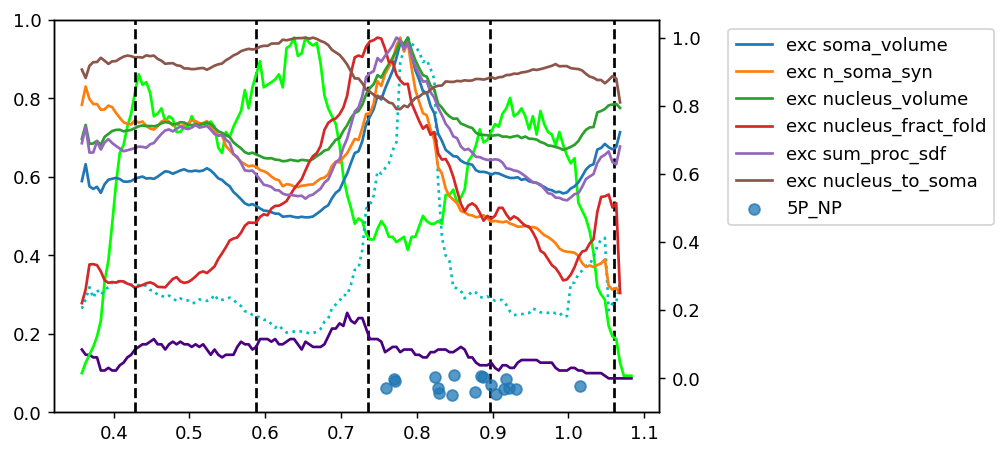

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=130)
ax2 = ax.twinx()
ax2.plot(bin_centers, inh_soma_densities / np.nanmax(exc_soma_densities), c="indigo") #, label="inh soma density")
ax2.plot(bin_centers, exc_soma_densities / np.nanmax(exc_soma_densities), c="lime") #, label="exc soma density")
ax2.plot(bin_centers, exc_soma_vol_std_by_depth / np.nanmax(exc_soma_vol_std_by_depth), color="c", linestyle=":") #, label="exc soma_volume std")

# for i in range(Yc.shape[0]):
#     c = colors[i % len(colors)]
#     ax2.plot(bin_centers, Yc[i, :], color=c, label=f"PCA mode {i}")
#     ax2.plot(bin_centers, model_means[:, i], linestyle="-.", color=c )
#     ax2.fill_between(bin_centers, model_means[:, i] - model_stds[:, i], model_means[:, i] + model_stds[:, i], edgecolor="none", facecolor=c, alpha=0.2)
#     
for i, f in enumerate(features):
    c = colors[i % len(colors)]
    ax2.plot(bin_centers, exc_soma_features_by_depth[f] / np.nanmax(exc_soma_features_by_depth[f]), linestyle="-", color=c, label="exc " + f)
#     ax2.plot(bin_centers, normalized_smooth_exc_features[f], linestyle=":", label="exc fit " + f)
#     ax2.plot(bin_centers, inh_soma_features_by_depth[f] / max(inh_soma_features_by_depth[f]), linestyle="-", label="inh " + f)
#     ax2.plot(bin_centers, soma_features_by_depth[f] / max(soma_features_by_depth[f]), linestyle="-", label=f)

# ax.plot(bin_centers, synapse_densities, label="syn")
# for t in syn_densities_by_pre:
#     ax2.plot(bin_centers, syn_densities_by_pre[t], label=t)
# for t in syn_densities_by_post:
#     ax2.plot(bin_centers, syn_densities_by_post[t], label=t)
# for i, t in enumerate(possible_subtypes):
#     cur = cell_subtypes.query(f"subtype == '{t}'").mm_depth.values
#     plt.scatter(cur, np.random.normal(-0.03, 0.025, len(cur)), color=colors[i], alpha=0.75, label=t)
for i, t in [(0, "5P_NP")]: #enumerate(possible_exc_subclasses):
    cur = auto_col_cells.query(f"cell_type == '{t}'").mm_depth.values
    plt.scatter(cur, np.random.uniform(-0.05, 0.01, len(cur)), color=colors[i], alpha=0.75, label=t)

    
ax2.axvline(labels[0], linestyle="--", color="k") #, label="manual")
for lab in labels[1:]:
    ax.axvline(lab, linestyle="--", color="k")
# ax2.axvline(bounds[0], linestyle="--", color="blue") #, label="automatic")
# for bound in bounds[1:]:
#     ax2.axvline(bound, linestyle="--", color="blue")
# ax.legend(bbox_to_anchor=[1.1, 1])
ax2.legend(bbox_to_anchor=[1.1, 1])
ax2.set_xlabel("depth ($mm$)")
# ax.set_ylabel("soma density (per $mm^{3}$)")
# ax2.set_ylabel("synapse density (per $mm^3$)")
plt.show()

In [205]:
auto_col_cells.query(f"cell_type == '5P_NP'").pt_root_id.values

array([864691135941359220, 864691135307222086, 864691135478381254,
       864691135272322833, 864691136123917094, 864691135850771655,
       864691135508942089, 864691136194415080, 864691136273892365,
       864691135644655343, 864691135467814540, 864691136084257900,
       864691136134678667, 864691135122533159, 864691135355173327,
       864691135939606529, 864691136023967801, 864691136922980324],
      dtype=int64)

# Hidden Markov Model implementation

In [81]:
from hmmlearn import hmm

In [82]:
# hmm.GaussianHMM?

In [145]:
model = hmm.GaussianHMM(n_components=6, covariance_type="diag", init_params="", params="mc", n_iter=1)
# the model starts in the first state, and there is 0 probability of starting elsewhere
model.startprob_ = np.zeros(model.n_components)
model.startprob_[0] = 1
p = 0.04
transition_probs = np.full(model.n_components - 1, p)
stay_probs = np.full(model.n_components, 1-p)
stay_probs[-1] = 1  # nothing deeper than white matter
model.transmat_ = np.diag(stay_probs) + np.diag(transition_probs, k=1)
model.transmat_

array([[0.96, 0.04, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.96, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [84]:
use_depth = True
varis = Yc.T
if use_depth:
    varis = np.hstack([varis, clean_nans(exc_soma_depths, normalize=True).reshape(-1, 1)])

In [85]:
# initialize means and variances
nf = varis.shape[1]
default_bounds = np.array([0.3, 0.400516, 0.555516, 0.700516, 0.830516, 1.010516, 1.1])  # from HMM trained on 2 PCA modes in column
model.means_ = np.zeros((model.n_components, nf))
covars = np.ones((model.n_components, nf))
for i in range(model.n_components):
    idxs = (default_bounds[i] <= bin_centers) & (bin_centers < default_bounds[i + 1])
    model.means_[i, :] = varis[idxs, :].mean(axis=0)
    covars[i, :] = varis[idxs, :].var(axis=0) + 1e-10
model.covars_ = covars
    
if use_depth:
    depth_centers = model.means_[:, -1]  # to help reduce major errors, these will be the means for the depth emissions

observables, hidden_states = model.sample(101)

In [86]:
prev_score = -1
score = model.score(varis)
max_iters = 100
tol = 0.001
i = 0
while abs(score - prev_score) > tol and i < max_iters:
    model.fit(varis)
    prev_score = score
    score = model.score(varis)
    print(score)
    i += 1
    # model.means_[[0, -1]] = 0  # means for L1 and WM exc soma density should be 0 (I should instead not use the HMM for this, just a threshold)
    if use_depth:
        # each iteration re-fix the "target" mean depth to the center of each default layer
        # so the model can't be terribly wrong
        model.means_[:, -1] = depth_centers
    print("after correction:", model.score(varis))
    
if abs(score - prev_score) > tol:
    raise ValueError("Did not converge")

165.32624782004982
after correction: 165.18214730289375
168.73830377766504
after correction: 168.30291248217404
171.06824724139142
after correction: 170.40313683472667
172.10775423746318
after correction: 171.36787393330548
172.36794433198722
after correction: 171.62093886479636
172.44973100991783
after correction: 171.71026124201668
172.49701048967364
after correction: 171.76610173848988
172.53179405619176
after correction: 171.80783691428132
172.55904392173935
after correction: 171.84031112916296
172.580709726691
after correction: 171.86583073573613
172.59799943585963
after correction: 171.8859658780533
172.6118256882085
after correction: 171.90191021468507
172.6229088966645
after correction: 171.91458687118714
172.63181795286212
after correction: 171.92470794077636
172.63899993282897
after correction: 171.93282152135006
172.64480551959912
after correction: 171.93935006398888
172.64951015756245
after correction: 171.94462054946774
172.65333093655588
after correction: 171.948887532174

In [87]:
layers = model.predict(varis).tolist()

In [88]:
str(layers)

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]'

In [89]:
bounds = []
for i in range(1, model.n_components):
    idx = layers.index(i)
    bounds.append((bin_centers[idx] + bin_centers[idx-1]) / 2)
    print(bin_centers[idx])
bounds = np.array(bounds)

0.40301600000000004
0.5580160000000002
0.6980160000000003
0.8480160000000004
1.0130160000000006


In [90]:
model_means = np.array([model.means_[l] for l in layers])
model_stds = np.array([np.diagonal(np.sqrt(model.covars_[l])) for l in layers])
model_means, model_stds

(array([[ 0.01291211, -0.70117581,  1.74964165, ..., -0.03515673,
          0.06093547, -1.58781314],
        [ 0.01291211, -0.70117581,  1.74964165, ..., -0.03515673,
          0.06093547, -1.58781314],
        [ 0.01291211, -0.70117581,  1.74964165, ..., -0.03515673,
          0.06093547, -1.58781314],
        ...,
        [ 0.04665182, -2.4646269 , -0.31864476, ..., -0.0451766 ,
         -0.07037827,  1.52698845],
        [ 0.04665182, -2.4646269 , -0.31864476, ..., -0.0451766 ,
         -0.07037827,  1.52698845],
        [ 0.04665182, -2.4646269 , -0.31864476, ..., -0.0451766 ,
         -0.07037827,  1.52698845]]),
 array([[0.27786775, 0.38025133, 0.24051822, ..., 0.09035585, 0.06516923,
         0.06713758],
        [0.27786775, 0.38025133, 0.24051822, ..., 0.09035585, 0.06516923,
         0.06713758],
        [0.27786775, 0.38025133, 0.24051822, ..., 0.09035585, 0.06516923,
         0.06713758],
        ...,
        [0.65507607, 0.75186692, 0.42318014, ..., 0.13478792, 0.11520517

In [91]:
posteriors = model.predict_proba(varis)

# Plot model results!

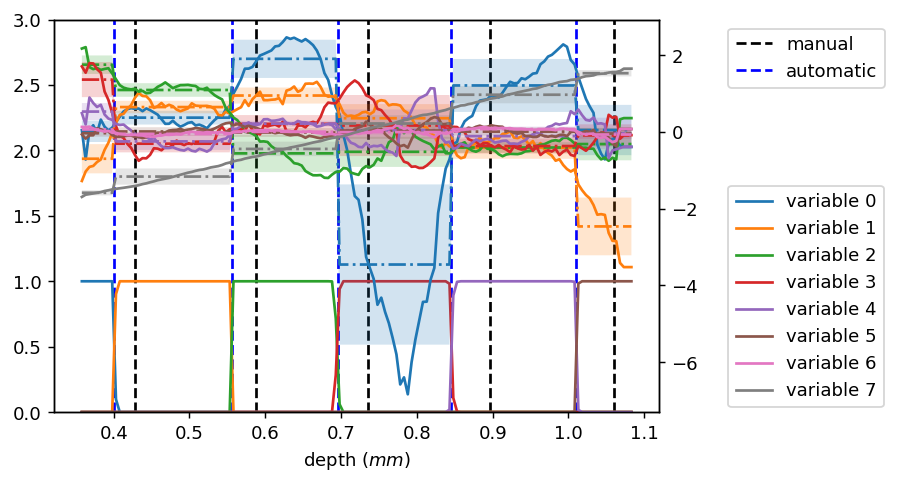

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=130)
ax2 = ax.twinx()

for i in range(varis.shape[1]):
    c = colors[i % len(colors)]
    ax2.plot(bin_centers, varis[:, i], color=c, label=f"variable {i}")
    ax2.plot(bin_centers, model_means[:, i], linestyle="-.", color=c )
    ax2.fill_between(bin_centers, model_means[:, i] - model_stds[:, i], model_means[:, i] + model_stds[:, i], edgecolor="none", facecolor=c, alpha=0.2)
#     
# for i, f in enumerate(features):
#     c = colors[i % len(colors)]
#     ax2.plot(bin_centers, exc_soma_features_by_depth[f] / np.nanmax(exc_soma_features_by_depth[f]), linestyle="-", color=c, label="exc " + f)
#     ax2.plot(bin_centers, model_means[:, i + 2], linestyle="-.", color=c, label="exc "+ f + " model mean")
#     ax2.fill_between(bin_centers, model_means[:, i+2] - model_stds[:, i+2], model_means[:, i+2] + model_stds[:, i+2], edgecolor="none", facecolor=c, alpha=0.2)
#     ax2.plot(bin_centers, normalized_smooth_exc_features[f], linestyle=":", label="exc fit " + f)
#     ax2.plot(bin_centers, inh_soma_features_by_depth[f] / max(inh_soma_features_by_depth[f]), linestyle="-", label="inh " + f)
#     ax2.plot(bin_centers, soma_features_by_depth[f] / max(soma_features_by_depth[f]), linestyle="-", label=f)

# ax.plot(bin_centers, synapse_densities, label="syn")
# for t in syn_densities_by_pre:
#     ax2.plot(bin_centers, syn_densities_by_pre[t], label=t)
# for t in syn_densities_by_post:
#     ax2.plot(bin_centers, syn_densities_by_post[t], label=t)
    
ax.axvline(labels[0], linestyle="--", color="k", label="manual")
for lab in labels[1:]:
    ax.axvline(lab, linestyle="--", color="k")
ax.axvline(bounds[0], linestyle="--", color="blue", label="automatic")
for bound in bounds[1:]:
    ax.axvline(bound, linestyle="--", color="blue")
ax.plot(bin_centers, posteriors)
ax.legend(bbox_to_anchor=[1.1, 1])
ax2.legend(bbox_to_anchor=[1.1, 0.6])
ax.set_xlabel("depth ($mm$)")
ax.set_ylim([0, 3])
# ax.set_ylabel("soma density (per $mm^{3}$)")
# ax2.set_ylabel("synapse density (per $mm^3$)")
plt.show()

### predicted layer boundaries as a function of number of PCA modes used

In [93]:
bounds

array([0.400516, 0.555516, 0.695516, 0.845516, 1.010516])

In [730]:
array([0.400516, 0.555516, 0.690516, 0.850516, 1.035516])  # all 7 PCA modes

array([0.400516, 0.555516, 0.690516, 0.850516, 1.035516])

In [716]:
array([0.400516, 0.555516, 0.695516, 0.845516, 1.035516])  # 6 PCA modes

array([0.400516, 0.555516, 0.695516, 0.845516, 1.035516])

In [674]:
array([0.400516, 0.555516, 0.700516, 0.825516, 1.035516])  # 3 PCA modes

array([0.400516, 0.555516, 0.700516, 0.825516, 1.035516])

In [ ]:
array([0.400516, 0.555516, 0.700516, 0.830516, 1.010516])  # 2 PCA modes

In [ ]:
array([0.400516, 0.555516, 0.690516, 0.855516, 1.035516])  # 1 PCA mode

# Sum of magnitudes of fft-smoothed derivatives

In [233]:
from scipy import fft

In [419]:
freq_cutoff = 0.05
cleaned = clean_nans(exc_soma_densities, divide_by_max=True)
e_fft = fft.fft(cleaned)
freqs = fft.fftfreq(len(exc_soma_densities))
mask = abs(freqs) < freq_cutoff
e_fft *= mask  # remove high frequency content (details/noise)
e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
normalized_smooth_exc_densities = np.real(fft.ifft(e_fft))
smooth_exc_soma_densities_deriv = np.real(fft.ifft(e_fft_prime))

normalized_smooth_exc_features = dict() 
smooth_exc_feature_derivs = dict()
for f in features:
    cleaned = clean_nans(exc_soma_features_by_depth[f], divide_by_max=True)
    e_fft = fft.fft(cleaned)
    freqs = fft.fftfreq(len(cleaned))
    mask = abs(freqs) < freq_cutoff
    e_fft *= mask  # remove high frequency content (details/noise)
    e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
    normalized_smooth_exc_features[f] = np.real(fft.ifft(e_fft))
    smooth_exc_feature_derivs[f] = np.real(fft.ifft(e_fft_prime))

In [421]:
transitionness = sum(np.abs(smooth_exc_feature_derivs[f]) for f in features) + smooth_exc_soma_densities_deriv

## another way to visualize

No handles with labels found to put in legend.


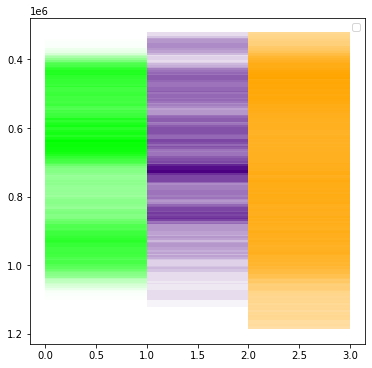

In [113]:
# todo fill with alpha = density
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(bin_centers)):
        bin_start, bin_end = bin_centers[i] - step_size // 2, bin_centers[i] + step_size // 2
        ax.fill_between([0, 1], [bin_start]*2, [bin_end]*2, alpha=exc_soma_densities[i] / max(exc_soma_densities), color="lime", edgecolor=None)
        ax.fill_between([1, 2], [bin_start]*2, [bin_end]*2, alpha=inh_soma_densities[i] / max(inh_soma_densities), color="indigo", edgecolor=None)
    
ax.invert_yaxis()
ax.legend()
plt.show()

## Ideas:
Use synapse_query(bounding_box) to get synapse density too (and stratify by cell type)

Use inhibitory cell subclass densities (do these use depth info? yes, so don't)

Use *excitatory* soma features (they're much less noisy than inhibitory/combined features) and look for significant and steep changes in these features with depth by using the fft-smoothed version of each feature (as a function of depth) and then take its derivative (in fourier domain). The magnitude of the derivative of the smoothed function indicates how much of a transition zone it is according to that feature, and if we take the product of these derivative magnitudes we should see peaks at the layer borders.

In [103]:
soma_features.columns

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')

In [50]:
bounds_by_x = np.array([np.array([0.458796, 0.548796, 0.703796, 0.843796, 1.013796]), np.array([0.443796, 0.543796, 0.703796, 0.843796, 1.013796]), np.array([0.431516, 0.546516, 0.681516, 0.836516, 0.996516]), np.array([0.426516, 0.546516, 0.681516, 0.816516, 0.911516]), np.array([0.445868, 0.540868, 0.675868, 0.825868, 1.045868]), np.array([0.40222, 0.54222, 0.66222, 0.82722, 1.01222]), np.array([0.407548, 0.497548, 0.657548, 0.832548, 0.982548]), np.array([0.407548, 0.502548, 0.657548, 0.832548, 0.987548]), np.array([0.403756, 0.503756, 0.643756, 0.803756, 1.008756]), np.array([0.421556, 0.506556, 0.641556, 0.781556, 1.011556]), np.array([0.40842, 0.49842, 0.63342, 0.78342, 0.99842]), np.array([0.406764, 0.511764, 0.616764, 0.811764, 1.011764])])
bounds_by_x_use_depth = np.array([[0.45879600000000004, 0.5487960000000001, 0.7037960000000003, 0.8437960000000004, 1.0137960000000006], [0.443796, 0.5437960000000002, 0.7037960000000003, 0.8437960000000004, 1.0137960000000006], [0.42651600000000006, 0.5465160000000002, 0.6815160000000002, 0.8415160000000004, 0.9965160000000006], [0.42651600000000006, 0.5465160000000002, 0.6815160000000002, 0.8165160000000005, 0.9315160000000005], [0.43086800000000003, 0.5408680000000001, 0.6808680000000003, 0.8258680000000004, 1.0458680000000005], [0.42222000000000004, 0.5422200000000001, 0.6622200000000003, 0.8272200000000004, 1.0072200000000007], [0.412548, 0.5425480000000001, 0.6575480000000002, 0.8325480000000004, 0.9825480000000005], [0.42254800000000003, 0.5025480000000001, 0.6575480000000002, 0.8325480000000004, 0.9875480000000005], [0.403756, 0.5237560000000001, 0.6437560000000002, 0.8037560000000004, 1.0087560000000004], [0.44155600000000006, 0.5115560000000001, 0.6415560000000002, 0.7815560000000004, 1.0115560000000006], [0.40842, 0.4984200000000001, 0.6384200000000002, 0.7834200000000003, 0.9984200000000005], [0.406764, 0.5217640000000001, 0.6167640000000002, 0.8267640000000004, 1.0117640000000006]])
bounds_by_x_use_depth_changing_default = np.array([[0.3983493333333334, 0.5555160000000001, 0.7005160000000004, 0.8455160000000004, 1.0505160000000004], [0.39179200000000003, 0.5442920000000002, 0.7042920000000004, 0.8442920000000005, 1.0489348571428578], [0.39261133333333337, 0.5480280000000002, 0.6880280000000003, 0.8430280000000004, 1.0388613333333339], [0.38261133333333336, 0.5480280000000002, 0.6830280000000003, 0.8180280000000004, 1.0294168888888895], [0.3724312727272728, 0.5422040000000001, 0.6722040000000002, 0.8272040000000005, 1.0318468571428576], [0.37105415384615387, 0.5447080000000002, 0.6647080000000003, 0.8297080000000004, 1.0257794285714292], [0.3773926666666667, 0.5394760000000002, 0.6594760000000003, 0.8294760000000004, 1.020547428571429], [0.38147600000000004, 0.5044760000000001, 0.6544760000000003, 0.8294760000000004, 1.0119760000000007], [0.3850036363636364, 0.5061400000000001, 0.6461400000000003, 0.8011400000000004, 1.0023900000000006], [0.38454909090909095, 0.5061400000000001, 0.6411400000000003, 0.7811400000000004, 0.9923900000000005], [0.3867716923076923, 0.49696400000000013, 0.6369640000000003, 0.7769640000000004, 0.9969640000000006], [0.3861946666666667, 0.5020280000000001, 0.6270280000000003, 0.7870280000000004, 0.9961946666666672]])
bounds_by_x_use_depth_changing_default_by_25 = np.array([[0.3983493333333334, 0.5555160000000001, 0.7005160000000004, 0.8455160000000004, 1.0505160000000004], [0.3971826666666667, 0.5455160000000001, 0.7005160000000004, 0.8405160000000005, 1.0511410000000005], [0.39179200000000003, 0.5442920000000002, 0.7042920000000004, 0.8442920000000005, 1.0489348571428578], [0.39250628571428575, 0.5442920000000002, 0.6942920000000004, 0.8442920000000005, 1.0457920000000005], [0.39261133333333337, 0.5480280000000002, 0.6880280000000003, 0.8430280000000004, 1.0388613333333339], [0.39052800000000004, 0.5480280000000002, 0.6880280000000003, 0.8180280000000004, 1.0305280000000006], [0.38261133333333336, 0.5480280000000002, 0.6830280000000003, 0.8180280000000004, 1.0294168888888895], [0.37214800000000003, 0.5451480000000002, 0.6851480000000003, 0.8051480000000004, 1.0290765714285721], [0.3724312727272728, 0.5422040000000001, 0.6722040000000002, 0.8272040000000005, 1.0318468571428576], [0.3705413333333334, 0.5447080000000002, 0.6647080000000003, 0.8147080000000004, 1.0309580000000007], [0.37105415384615387, 0.5447080000000002, 0.6647080000000003, 0.8147080000000004, 1.0257794285714292], [0.37720800000000004, 0.5397080000000002, 0.6547080000000003, 0.8297080000000004, 1.0244807272727279], [0.3773926666666667, 0.5444760000000002, 0.6544760000000003, 0.8294760000000004, 1.020547428571429], [0.37788509090909095, 0.5044760000000001, 0.6594760000000003, 0.8294760000000004, 1.0159760000000007], [0.38147600000000004, 0.5044760000000001, 0.6594760000000003, 0.8294760000000004, 1.0119760000000007], [0.38197600000000004, 0.5044760000000001, 0.6494760000000003, 0.8294760000000004, 1.0086426666666672], [0.3850036363636364, 0.5061400000000001, 0.6461400000000003, 0.8011400000000004, 1.0023900000000006], [0.38864000000000004, 0.5061400000000001, 0.6461400000000003, 0.7861400000000004, 0.9996400000000006], [0.38454909090909095, 0.5061400000000001, 0.6411400000000003, 0.7811400000000004, 0.9923900000000005], [0.3872763636363637, 0.5011400000000001, 0.6361400000000003, 0.7761400000000004, 0.9953066666666672], [0.3867716923076923, 0.49696400000000013, 0.6369640000000003, 0.7769640000000004, 0.9969640000000006], [0.3867973333333334, 0.5019640000000001, 0.6319640000000002, 0.7869640000000004, 0.9957140000000005], [0.3861946666666667, 0.5020280000000001, 0.6270280000000003, 0.7870280000000004, 0.9961946666666672], [0.38452800000000004, 0.5120280000000001, 0.6170280000000002, 0.7870280000000004, 0.9953613333333339], [0.3797653333333334, 0.5139320000000002, 0.6139320000000003, 0.7889320000000004, 0.9904320000000005], [0.37337600000000004, 0.5158760000000002, 0.6108760000000002, 0.7808760000000003, 0.9876617142857149], [0.376309090909091, 0.5179000000000002, 0.6079000000000003, 0.7929000000000004, 0.9904000000000006]])

Text(0.5, 1.0, 'layer boundaries X-Y cross section')

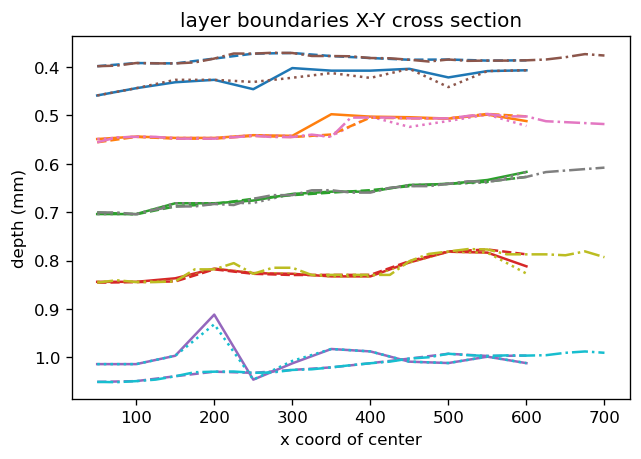

In [55]:
fig, ax = plt.subplots(dpi=120)
ax.plot(range(50, 650, 50), bounds_by_x)
ax.plot(range(50, 650, 50), bounds_by_x_use_depth, linestyle=":")
ax.plot(range(50, 650, 50), bounds_by_x_use_depth_changing_default, linestyle="--")
ax.plot(range(50, 725, 25), bounds_by_x_use_depth_changing_default_by_25, linestyle="-.")
ax.set_xlabel("x coord of center")
ax.set_ylabel("depth (mm)")
ax.invert_yaxis()
ax.set_title("layer boundaries X-Y cross section")

In [191]:
np.nonzero(exc_soma_densities > 50_000)[0][-1]

138

In [14]:
bbox

array([[168111.,  50000.,  20133.],
       [193111., 323500.,  22633.]])

In [25]:
seg_low_um = np.array([130_000, 50_000, 15_000]) * resolution / 1_000  # This is a conservative bbox only containing well-segmented areas
seg_up_um = np.array([355_000, 323_500, 27_500]) * resolution / 1_000
seg_size_um = seg_up_um - seg_low_um
seg_bounds_vx = np.array([seg_low_um, seg_up_um]) * 1_000 / resolution
seg_bounds_vx

array([[130000.,  50000.,  15000.],
       [355000., 323500.,  27500.]])

In [28]:
seg_up_um

array([1420., 1294., 1100.])

In [30]:
1420 - 672444 / 1_000

747.556

In [32]:
273_731 * 4 - 672444

422480